Para este notebook utilizaremos uma outra base de dados sobre aluguel de bicicletas.

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

mpl.rcParams['figure.figsize'] = (12,6)

# Configurando a fonte de forma global
mpl.rcParams['font.size'] = 14

SEED = 42

### Análise exploratória

In [70]:
df = pd.read_csv('bicicletas.csv')
df.head()

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datas        17414 non-null  object 
 1   contagem     17414 non-null  int64  
 2   temperatura  17414 non-null  float64
 3   sensacao     17414 non-null  float64
 4   umidade      17414 non-null  float64
 5   vel_vento    17414 non-null  float64
 6   clima        17414 non-null  float64
 7   feriado      17414 non-null  float64
 8   final_ds     17414 non-null  float64
 9   estacao      17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


Precisamos converter a coluna datas de object (string) para datetime.

In [72]:
df['datas'] = pd.to_datetime(df['datas'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datas        17414 non-null  datetime64[ns]
 1   contagem     17414 non-null  int64         
 2   temperatura  17414 non-null  float64       
 3   sensacao     17414 non-null  float64       
 4   umidade      17414 non-null  float64       
 5   vel_vento    17414 non-null  float64       
 6   clima        17414 non-null  float64       
 7   feriado      17414 non-null  float64       
 8   final_ds     17414 non-null  float64       
 9   estacao      17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

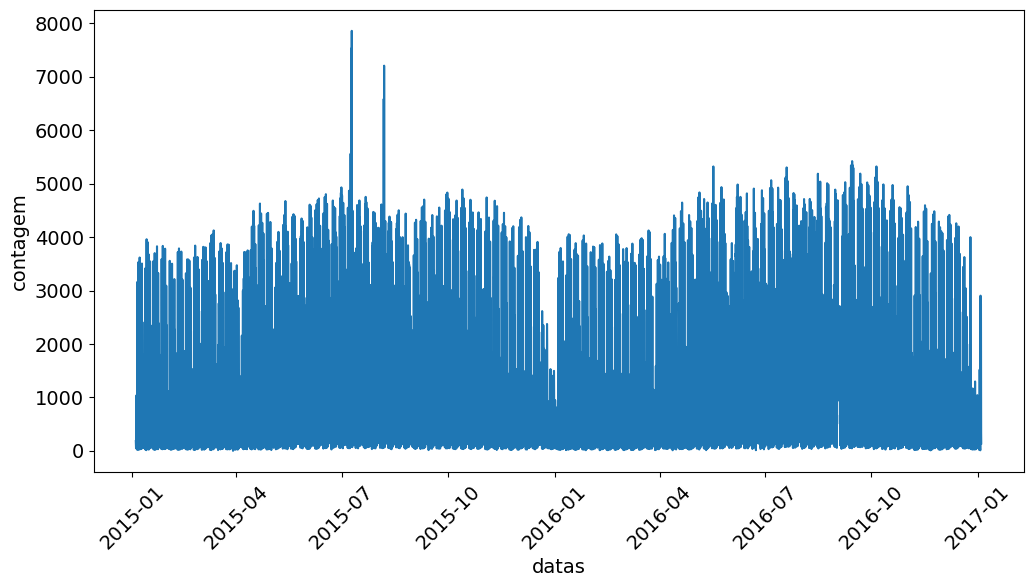

In [73]:
sns.lineplot(x='datas', y='contagem', data=df)
plt.xticks(rotation=45)

<Axes: ylabel='contagem'>

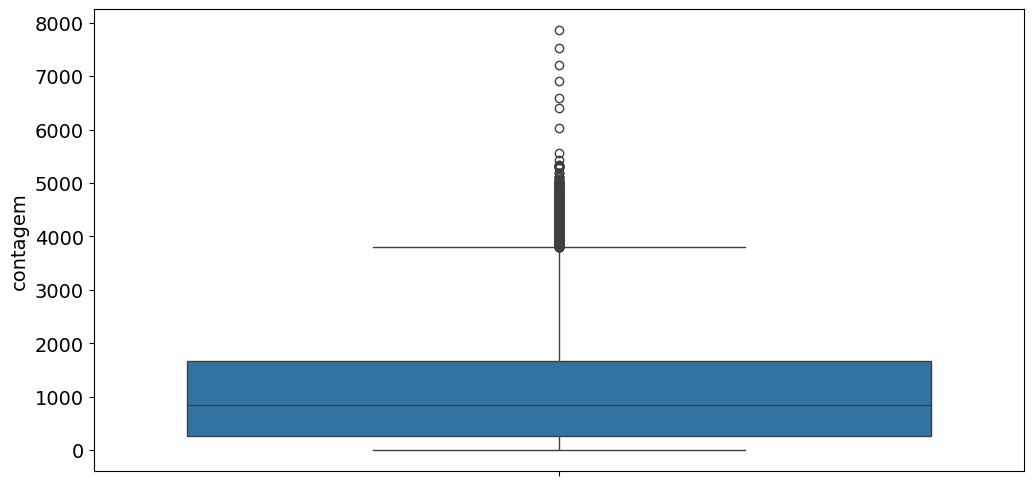

In [74]:
sns.boxplot(df['contagem'])

### Pré processamento

In [75]:
sc = StandardScaler()

# Necessário realizar o reshape pois o fit_transform espera que receba um array bi-dimensional
y = sc.fit_transform(df['contagem'].values.reshape(-1,1))

Separação do dado *contagem* entre treino e teste, aqui usaremos a mesma estratégia da preparação de dados de *séries temporais*.
- Iremos passar como dados de entrada e saída da rede neural o próprio retorno desejado (**contagem** de aluguel de bikes).

In [76]:
y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

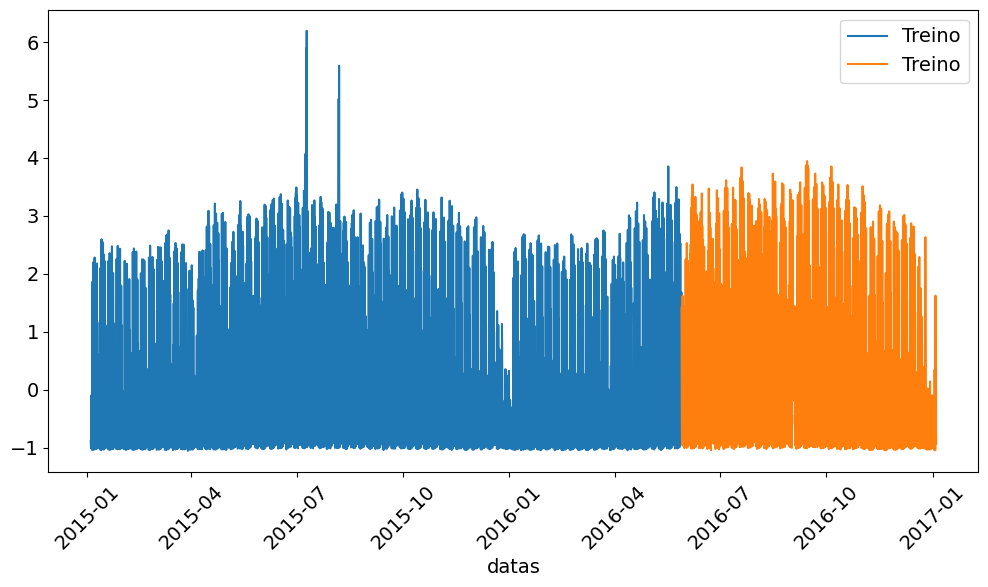

In [77]:
# Necessário fazer [:,0] pois o retorno de train_test_split é uma matriz, é necessário passar um vetor no x e y
sns.lineplot(x='datas', y=y_train[:,0], data=df[0:len(y_train)], label='Treino')
sns.lineplot(x='datas', y=y_test[:,0], data=df[len(y_train):len(y)], label='Treino')
plt.xticks(rotation=45)

Separação dos dados de séries temporais entre treino e teste usando a biblioteca *numpy*.

In [78]:
# Utilizando a biblioteca numpy para realizar a preparação dos dados de séries temporais

n_length = 10
y_train_array = y_train[:,0]
windows = sliding_window_view(y_train_array, window_shape=n_length +1)

y_train_time_series = windows[:, :-1]
y_test_time_series = windows[:, -1]

### Redes Neurais Recorrentes

Até o momento nós usamos um *perceptron* (redes neurais de múltiplas camadas), representado por camadas de entrada, camadas escondidas e saídas. Porém, esse tipo de arquitetura não entende muito bem o caráter sequencial das séries temporais, onde **cada uma das observações está correlacionada**.

A correlação na série temporal é como uma **memória que carrega a informação da própria série temporal**.

Existe um outro tipo de arquitetura de rede que é feita para aproveitar da informação sequencial nos dados, essa arquitetura é a das **redes neurais recorrentes**.

Uma representação da recorrência da série em **receber a parte anterior de forma sequencial**, pode ser feita através de um **loop**. Nesse caso, um *loop* pode indicar a recorrência. Podemos ter uma estrutura para as redes recorrentes, como sefossem uma versão achatada da série, onde cada uma das camadas escondidas possuem esses loops.

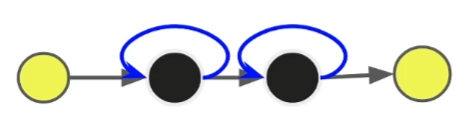

**O que a rede recorrente espera?**
- Espera uma entrada de uma matriz tri-dimensional.
- Terceira dimensão será o número de atributos por passo no tempo.